In [1]:
import time
import pickle
import glob

In [2]:
import numpy as np

In [3]:
import awkward as ak

In [4]:
import matplotlib.pyplot as plt

In [17]:
import sklearn.cluster

In [5]:
# http://millionsongdataset.com/pages/field-list/
songs = ak.from_parquet("~/storage/data/million-song-dataset/full/millionsongs", lazy=True)
songs

<Array [...] type='1000000 * {"hdf5_filename": string, "analysis": {"bars": var ...'>

In [6]:
key_shift = ak.Array([
    [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
    [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0],
    [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1],
    [ 3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2],
    [ 4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3],
    [ 5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4],
    [ 6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5],
    [ 7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6],
    [ 8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7],
    [ 9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8],
    [10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
    [11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
])

In [6]:
# some_songs = songs[:10000]
some_songs = ak.Array(songs.layout.partitions[0])

In [7]:
shift_for_song = key_shift[some_songs.analysis.key]

In [8]:
shifted_pitches = some_songs.analysis.segments.pitches[shift_for_song[:, np.newaxis]]

In [9]:
sorted_pitches = ak.argsort(shifted_pitches, axis=-1)

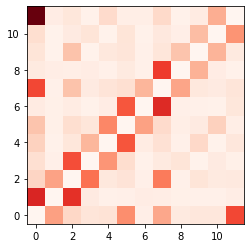

In [10]:
second_loudest = sorted_pitches[:, :, -2]
first_loudest = sorted_pitches[:, :, -1]

fig, ax = plt.subplots(1, 1)
ax.hist2d(
    np.asarray(ak.flatten(first_loudest)),
    np.asarray(ak.flatten(second_loudest)),
    bins=(12, 12),
    range=((-0.5, 11.5), (-0.5, 11.5)),
    cmap="Reds",
);
ax.set_aspect(1)

In [11]:
loudest_pitches = ak.argmax(shifted_pitches, axis=-1)

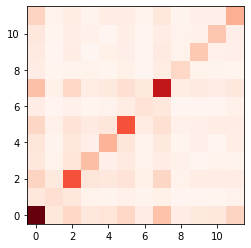

In [12]:
before = loudest_pitches[:, :-1]
after = loudest_pitches[:, 1:]

fig, ax = plt.subplots(1, 1)
ax.hist2d(
    np.asarray(ak.flatten(before)),
    np.asarray(ak.flatten(after)),
    bins=(12, 12),
    range=((-0.5, 11.5), (-0.5, 11.5)),
    cmap="Reds",
)
ax.set_aspect(1)

In [13]:
segment_new_loudest = ak.concatenate([True, before != after], axis=1)

In [14]:
segment_loudest_change = ak.local_index(shifted_pitches, axis=1)[segment_new_loudest]

In [15]:
run_length = segment_loudest_change[:, 1:] - segment_loudest_change[:, :-1]

In [16]:
last_run = ak.num(shifted_pitches) - ak.sum(run_length, axis=-1)

In [17]:
full_run_length = ak.concatenate([ak.fill_none(run_length, 0), last_run[:, np.newaxis]], axis=1)

In [18]:
grouped_by_same_loudest = ak.unflatten(ak.flatten(shifted_pitches), ak.flatten(full_run_length))

In [19]:
mean_in_each_group = ak.mean(grouped_by_same_loudest, axis=1)

In [20]:
pitches_in_runs = ak.unflatten(mean_in_each_group, ak.num(full_run_length))

In [21]:
loudest_in_runs = ak.argmax(pitches_in_runs, axis=-1)

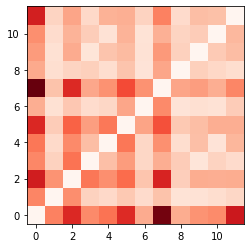

In [22]:
before = loudest_in_runs[:, :-1]
after = loudest_in_runs[:, 1:]

fig, ax = plt.subplots(1, 1)
ax.hist2d(
    np.asarray(ak.flatten(before)),
    np.asarray(ak.flatten(after)),
    bins=(12, 12),
    range=((-0.5, 11.5), (-0.5, 11.5)),
    cmap="Reds",
)
ax.set_aspect(1)

In [94]:
interval_numbers = loudest_in_runs[:, :-1] + 12 * loudest_in_runs[:, 1:]

In [95]:
interval_numbers

<Array [[69, 113, 93, 7, ... 115, 57, 88, 79]] type='1000 * var * ?int64'>

In [97]:
numbers_to_match = ak.Array(np.arange(144))[np.newaxis, np.newaxis, :]

In [98]:
intervals_per_song = ak.mean(interval_numbers == numbers_to_match, axis=1)

In [100]:
np_intervals_per_song = np.asarray(intervals_per_song)

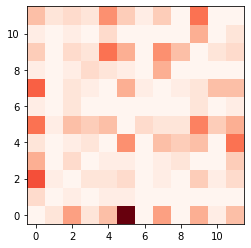

In [107]:
before = loudest_in_runs[0, :-1]
after = loudest_in_runs[0, 1:]

fig, ax = plt.subplots(1, 1)
ax.hist2d(
    np.asarray((before)),
    np.asarray((after)),
    bins=(12, 12),
    range=((-0.5, 11.5), (-0.5, 11.5)),
    cmap="Reds",
)
ax.set_aspect(1)

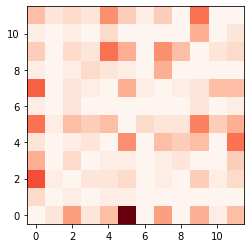

In [109]:
plt.imshow(np_intervals_per_song[0].reshape(12, 12), origin="lower", cmap="Reds")

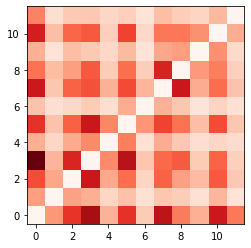

0.04 William Shatner_ David Itkin_ The Arkansas Symphony Orchestra_ Paul Rowe: Exodus: Part I: Moses and Pharaoh
0.05 The Association: Ron's Reverie: Across The Field / Carmen Ohio (Album Version)
0.05 Sonny Rollins Quartet: Paul's Pal
0.05 Howard Armstrong: My Four Reasons
0.06 Osanna: Oro Caldo
0.06 The Four Preps: The Big Draft Medley
0.06 Kitty Margolis: Midnight Sun
0.06 The Shadow Ring: Crystal Tears
0.06 Aretha Franklin: RUNNIN' OUT OF FOOLS
0.06 Chick Corea / Béla Fleck: Sunset Road


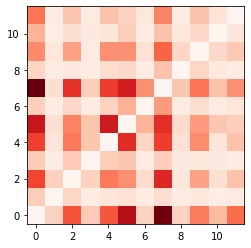

0.06 Halle/Hughes: Valse Triste (Kuolema Op 44)
0.06 Francis Dunnery: Too Much Saturn
0.07 Earl Anderza: You'd Be So Nice To Come Home To (1998 Digital Remaster)
0.07 Erskine Hawkins and His Orchestra: Let's Go Home
0.07 Xavier Cugat: Amor_ Amor_ Amor
0.07 Miguel Gallardo: Eternamente Amame
0.07 Sebastian: Bear With Me
0.07 The Corrs: Love Gives Love Takes ( LP Version )
0.07 Stuff Smith: C Jam Blues
0.07 Bud Powell: Embraceable You


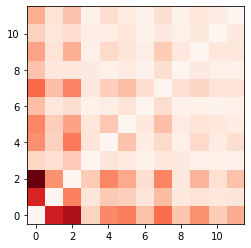

0.07 Olle Adolphson: Tatuerarevalsen (remaster '03)
0.07 Lil Johnson: Love Thief
0.08 Smartbomb: Complicate It
0.08 Alejandro Sanz: Corazon Partio Club Mix Edit
0.08 Chuck Loeb: New Life
0.08 Los Rieleros Del Norte: Usted
0.08 The Verve Pipe: Medicate Myself
0.08 Camilo Sesto: Llueve Sobre Mojado
0.08 Jam Hsiao: Green Door
0.08 Gary Hobbs: The Look Of Love


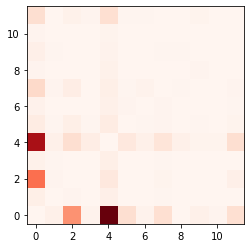

0.13 Public Image Ltd: (This Is Not A) Love Song (Live)
0.14 Taras: I Will Love Again (JJ's Club Radio)
0.17 Mike Shiver: Feelings
0.17 Explicit Samouraï: X.plicit sentence
0.2 Polygon Window: Quino-Phec
0.26 Trees of mint: And so on...
0.3 The Tyrant Lizard Kings: Delete All Alarms


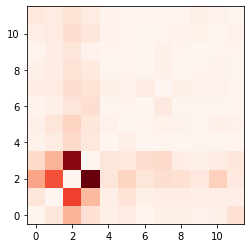

0.09 Maxi Priest: Groovin' In The Midnight
0.1 Lady Sovereign: Bang Bang
0.11 Aphex Twin: Come On You Slags
0.11 Ec8or: Cocain Ducks
0.12 Primal Scream: Pills
0.13 Coldfeet: Shamefaced (Francois K Dub Mix)
0.13 DJ X-Change featuring DJ Joey A: Come Over
0.14 Tassilli Players: Interstellar Overdub
0.14 Scenario Rock: Perfect Love Antidote BoBmo First Remix
0.14 Nine Inch Nails: The Frail


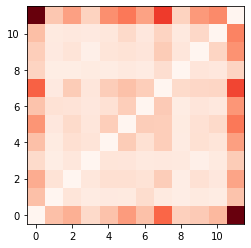

0.07 Faiz Ali Faiz: Sohna Nee Sohna Data
0.08 The Berzerker: Deform (live)
0.08 Flux of Pink Indians: Take Heed
0.08 Lorena: Footloose
0.08 The Babys: Love Is Just A Mystery
0.08 Barbara McNair: The Shadow Of Your Smile
0.08 Flor Silvestre: Caricia Y Herida
0.09 Stretch Arm Strong: Pursuit Of Happiness
0.09 Deadlock: We Shall All Bleed
0.09 Rocola Bacalao: Jose Garbanzo


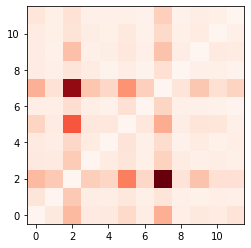

0.08 Napalm Death: The World Keeps Turning
0.08 Scred Connexion: Freestyle 35 (feat. Les Spécialistes)
0.09 Chuck Loeb: The Music Inside
0.09 Damien Dempsey: Industrial School
0.09 Saratoga: Semillas de odio
0.09 Hildegard Knef: Gestern hab' ich noch nachgedacht (Live)
0.09 Organized Konfusion: Hate
0.09 Blue Rodeo: Floating
0.09 Lonnie Mack: Down In The Dumps  (LP Version)
0.09 Van Halen: Panama (Remastered Album Version)


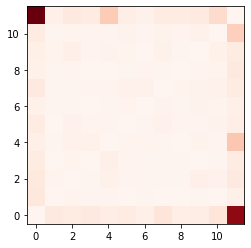

0.09 Dru Down: Rock It Don't Stop It
0.09 Borialis: Hourglass
0.1 Riccardo Fogli: Sulla buona strada
0.11 Jazz Addixx: Say Jazzy
0.11 Massimo Volume: La Notte Dell'11 Ottobre
0.12 Discofamily: It Just Won't Do
0.13 Carl Cox Vs Yousef: I Want You (Forever)
0.13 Kevin Gordon: Marina Takes Her Aim
0.13 Top Billin: My Girl Wants
0.14 Axel Karakasis: Hands In The Pocket


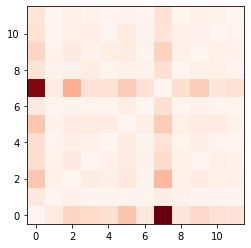

0.07 Toby Lightman: One Day
0.07 Bob Neuwirth: Biding Her Time
0.08 Frank Reyes: Ya No Te Creo Nada
0.08 Doctor Butcher: Freaks
0.08 Merle Haggard And The Strangers: Folsom Prison Blues
0.09 Chris Brashear: Little Home In Tennessee
0.09 Solistiyhtye Suomi: Teräslintu
0.09 Jeff And Sheri Easter: The Moon And I (Ordinary Day Album Version)
0.09 Jacob Miller: Mixed Up Moods
0.09 Rory Block: Three Is a Crowd


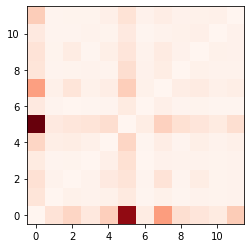

0.06 DJ Dips: Gerra De De
0.07 Jolin Tsai: Le Yuan (OT:They)
0.08 Jacob Young: In A Subtle Way
0.09 GNR: Toxicidade
0.09 Charlie Feathers: Frankie & Johnny
0.1 The B-52's: Wig
0.1 Sofia Talvik: Arms and Armour
0.1 Nick Cave & The Bad Seeds: She Fell Away (2009 Digital Remaster)
0.11 Golden Boots: Buildings
0.11 Terry Winchell: Crazy Some


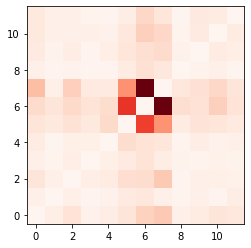

0.08 Med Flory: Bamboo
0.09 Paul Johnson: Just Dance!
0.1 The Devil Wears Prada: Danger: Wildman
0.11 Keith Urban: Everybody
0.11 Iwer George: Jump & Dunk
0.11 Ghostface Killah: Assassination Day
0.12 Foo Fighters: Hell
0.12 Joy Lynn White: The Lucky Few
0.12 Badly Drawn Boy: Tickets To What You Need
0.12 The Weathermen: Let Them Come To Berlin


In [218]:
model = sklearn.cluster.AgglomerativeClustering(distance_threshold=0.75, n_clusters=None).fit(np_intervals_per_song)
unique_labels = np.unique(model.labels_)

centers = []
for label in unique_labels:
    centers.append(np.mean(np_intervals_per_song[model.labels_ == label], axis=0).reshape(12, 12))
    
for center, label in zip(centers, unique_labels):
    plt.imshow(center, origin="lower", cmap="Reds")
    plt.show()
    distances = np.sqrt(np.sum((np_intervals_per_song[model.labels_ == label] - center.reshape(-1))**2, axis=1))
    sorter = np.argsort(distances)
    sorted_song_metadata = some_songs[model.labels_ == label, "metadata", ["artist_name", "title"]][sorter]
    for artist_title, dist in zip(sorted_song_metadata[:10].tolist(), distances[sorter][:10]):
        print(round(dist, 2), artist_title["artist_name"] + ": " + artist_title["title"])

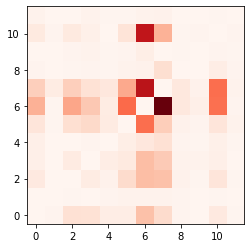

In [215]:
plt.imshow(np_intervals_per_song[some_songs.metadata.title == "Just Dance!"][0].reshape(12, 12), origin="lower", cmap="Reds")

# Scale-up

In [ ]:
collect_intervals_per_song = []

def doit(some_songs, partnum):
    if len(some_songs) > 0:
        shift_for_song = key_shift[some_songs.analysis.key]
        shifted_pitches = some_songs.analysis.segments.pitches[shift_for_song[:, np.newaxis]]
        loudest_pitches = ak.argmax(shifted_pitches, axis=-1)
        before = loudest_pitches[:, :-1]
        after = loudest_pitches[:, 1:]
        segment_new_loudest = ak.concatenate([True, before != after], axis=1)
        segment_loudest_change = ak.local_index(shifted_pitches, axis=1)[segment_new_loudest]
        run_length = segment_loudest_change[:, 1:] - segment_loudest_change[:, :-1]
        last_run = ak.num(shifted_pitches) - ak.sum(run_length, axis=-1)
        full_run_length = ak.concatenate([ak.fill_none(run_length, 0), last_run[:, np.newaxis]], axis=1)
        grouped_by_same_loudest = ak.unflatten(ak.flatten(shifted_pitches), ak.flatten(full_run_length))
        mean_in_each_group = ak.mean(grouped_by_same_loudest, axis=1)
        pitches_in_runs = ak.unflatten(mean_in_each_group, ak.num(full_run_length))
        loudest_in_runs = ak.argmax(pitches_in_runs, axis=-1)
        interval_numbers = loudest_in_runs[:, :-1] + 12 * loudest_in_runs[:, 1:]
        numbers_to_match = ak.Array(np.arange(144))[np.newaxis, np.newaxis, :]
        intervals_per_song = ak.mean(interval_numbers == numbers_to_match, axis=1)
        collect_intervals_per_song.append(intervals_per_song)
        pickle.dump(intervals_per_song, open(f"../million-song-tmp/intervals-{partnum:04d}.pkl", "wb"))

begin = time.time()
for partnum, partition in enumerate(songs.layout.partitions):
    partition_songs = ak.Array(partition)
    doit(partition_songs, partnum)
    print(partnum, "out of", len(songs.layout.partitions), "in", time.time() - begin, "seconds")

In [8]:
collect_intervals_per_song = []
for filename in glob.glob("../million-song-tmp/intervals-*.pkl"):
    with open(filename, "br") as file:
        collect_intervals_per_song.append(pickle.load(file))

In [22]:
np_intervals_per_song = np.concatenate([np.asarray(ak.fill_none(ak.pad_none(array, 144), 0)) for array in collect_intervals_per_song])

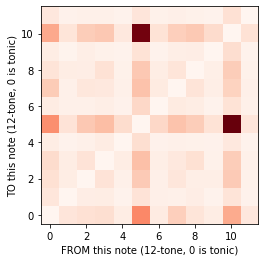

10306 in cluster, max distance = 0.9340727784238094
0.05 Buddy Holly: Come Back Baby
0.05 Jimmy Nelson: T-99 Blues
0.05 The Plimsouls: Hey! Hey! Hey! Hey!
0.05 Stonewall Jackson: Loving The Fool Out Of Me
0.05 Oak Ridge Boys: At The Roll Call
0.06 Klimperei: Locked in a white room
0.06 The Royal Family And The Poor: The Dawn Song
0.06 Curtis Salgado: Cookie Dough
0.06 Jérôme Richard: Perles De Cristal
0.06 Doug Dillard: With Care From Someone


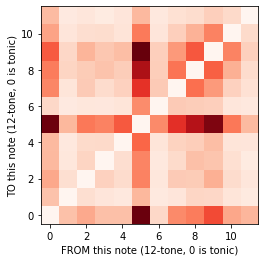

8705 in cluster, max distance = 0.3144089210429118
0.04 Tuó: Silence
0.04 Mother Superior: Moanin (Brand new recording)
0.04 George Acosta feat. Aruna: Fallin Backwards
0.04 Everything_ Now!: Angina Pectoris
0.05 Behind The Groove: What You Gonna Do About It? featuring Carla Prather
0.05 Ivy: Serre et monie
0.05 The Coal Porters: Drug Store Truck Driving Man
0.05 Boymerang: Still
0.05 Bloodbath: Hades Rising
0.05 Bad Habits: Personal Heroin


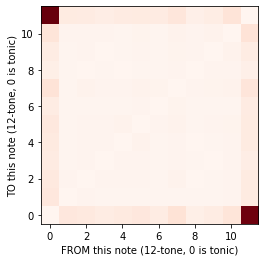

6584 in cluster, max distance = 0.6187361996238875
0.04 Carmen McRae: Can You Tell (LP Version)
0.04 Leroy Anderson: Horse And Buggy
0.05 Kaiser Chiefs: Out Of My Depth
0.05 The Real Kids: Reggae Reggae
0.05 Bloodbath: Outnumbering The Day
0.05 Oshmusik: Robots
0.05 Backstreet Boys: I Need You Tonight
0.05 Unwritten Law: Celebration Song (Album Version)
0.05 Pete Murray: Opportunity
0.05 Naglfar: Carnal Scorn & Spiritual Malice


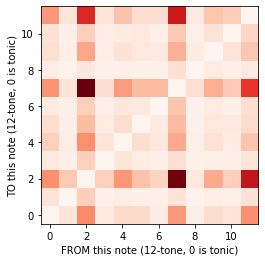

11143 in cluster, max distance = 0.38046053168635063
0.04 The New Birth: Come And Dream Some Paradise (Theme From Gordon's War)
0.04 Shelby Flint: House Of The Rising Sun (Album Version)
0.04 George Duke: La La
0.05 Solas: Vanished Like the Show
0.05 Shades of Al Davis: Ma Drew Hearts
0.05 mr76ix: Like Crack Whores Lapping Up Jizz
0.05 Delegation: Heartache
0.05 Tiga: Sex O'Clock
0.05 Beastie Boys: B-Boy Bouillabaisse: Mike On The Mic (2009 Digital Remaster)
0.05 Marco Paulo: Só Nós Dois


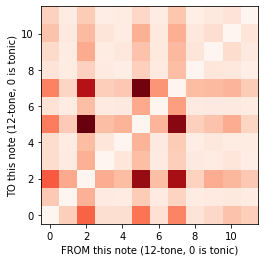

12078 in cluster, max distance = 0.35946399302079773
0.04 Atlantic Brass Quintet: Three Elizabethan Dances: Teares of the Muses
0.04 Plasma Expander: Nose On Belly
0.05 Grace Jones: Love Is The Drug
0.05 Heavenly: Spill Blood On Fire
0.05 Oldelaf_ Monsieur D: Le mont st-michel
0.05 The Contours: One Day Too Late
0.05 Bassboosa: Succumb (Tim Cox Radio Mix)
0.05 Jorge Ben Jor: Mas Que Nada
0.05 Didar Sandhu: Koi Na Jane Anjaan
0.05 Moral Crux: Breakdown


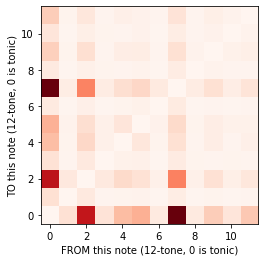

5603 in cluster, max distance = 0.5087882676430876
0.05 4ft Fingers: Unite Or Fall
0.05 Big Joe Williams: Banta Rooster Blues
0.05 David Lanz: Prelude To The Dance (Solo Piano)
0.06 Joan Baez: Edge Of Glory
0.06 Mouthful of Bees: Our Gold
0.06 Haemorrhage: Cadaveric Metamorphose
0.06 R. Kelly: Imagine That
0.06 Mastodon: Trainwreck
0.06 Red Velvet: Purple Diamond
0.06 The Child Molesters: Jet Trash Disco Date


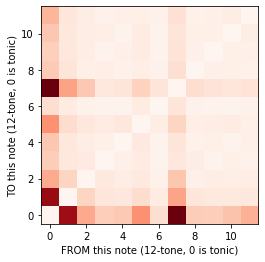

7399 in cluster, max distance = 0.3780968515842486
0.04 Lea Salonga: I Wanna Little Love
0.04 Jim Nabors: You'll Never Walk Alone
0.05 Everwake: Twilight Rising
0.05 Mighty Sam McClain: Somebody Help Me
0.05 Radio Birdman: Heyday
0.05 Don & Juan: True Love Never Runs Smooth
0.05 Francisco Araiza / Gottfried Hornik / Berliner Philharmoniker / Herbert von Karajan: Wie stark ist nicht dein Zauberton
0.05 Ellen Allien: Augenblick
0.05 Relax: Gib' mir deine Hand
0.05 Daniel Johnston: Laurie (Laurie EP)


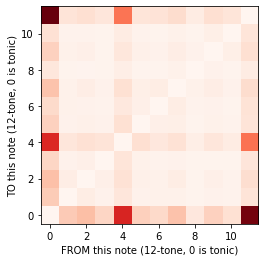

5643 in cluster, max distance = 0.441231830238535
0.04 Made In Sweden: Kristallen den grymma
0.05 Freddie & The Dreamers: Don't Make Me Cry
0.05 Jorge Celedon & Jimmy Zambrano: No Podran Separarnos
0.05 Nellie Lutcher: Come And Get It Honey
0.05 Adrian Sherwood: J'ai Changé
0.05 Ciro Visone_ Sara Pollino_ Pedro Del Mar: Sunset At Luminosity Beach
0.05 Sebkha-Chott: Mais qui a laissé cramer le chameau ?
0.05 Wonders: Freak (Tribal Remix By Sébastien Prado)
0.05 Saigon: Jailhouse Rap
0.05 Cyclone Temple: Me_ Myself & I


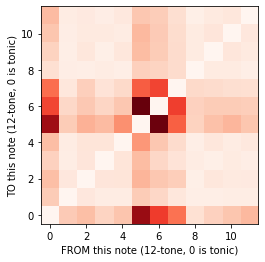

14954 in cluster, max distance = 0.3025312040468065
0.03 The Sainte Catherines: Westward Bound
0.04 Sharon Burch: Welcome Home (World)
0.04 Gene Ammons / Sonny Stitt Band: You Can Depend On Me
0.04 Annie Ross: What's New
0.04 Deep Voices feat. Torsten Verlinden: Another Day
0.04 Natalie Cole: I Haven't Got Anything Better To Do
0.04 Snow Patrol: An Olive Grove Facing The Sea
0.04 Mazarin: At 12 To 6
0.05 Smile Empty Soul: O'Lord
0.05 Guerilla Black: Genesis


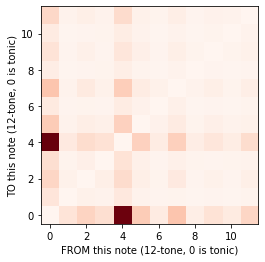

6221 in cluster, max distance = 0.894948677815304
0.05 Ryan Banks: The Return
0.06 Alain Caron: No Left Turn on Tuesday
0.06 Disco D: 6 A.M. Funk
0.06 Eric Benét: I Know (Album Version)
0.06 Unwrapped: Tupac Tribute Medley
0.06 Ordo Rosarius Equilibrio: [Mercury Rising] Seduced By the Kisses of Cinnabar Sweet
0.06 Glenn Branca_ Anthony Coleman_ F.L. Schröeder_ Harry Spitz_ Stephan Wischerth: Dissonance
0.06 101 Strings Orchestra: Getting To Know You
0.06 Tungtvann: T D Her
0.06 Afrojack: Polkadots


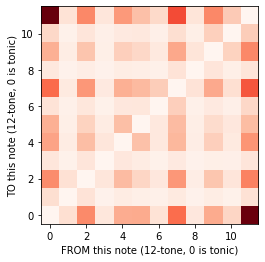

19046 in cluster, max distance = 0.6907960899808071
0.04 US Air Force Band of Flight: Phantom of the Opera
0.04 Onra: BOUNCE (interlude)
0.04 Camouflage: X-Ray (Tranceformer Single Mix)
0.04 The Gresham Flyers: Frittata
0.05 Big Country: The Selling Of America
0.05 The Neon Judgement: Are you Real?
0.05 Stan Rogers: Dark Eyed Molly
0.05 Sly Dunbar: Casava Piece Riddim
0.05 Bow Wow Wow: (I'm A) TV Savage
0.05 Avenged Sevenfold: Afterlife [Alternate Version]


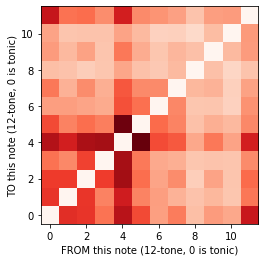

24562 in cluster, max distance = 0.9907160863908907
0.03 Blowsight: Toxic (Remastered Version)
0.03 Schola Cantorum Donibane: Urrikal jauna
0.03 Lisa Lashes: French Kiss
0.03 Bertrand Soulier: Stupide
0.03 Matias Aguayo: Minimal
0.03 Fourplay: Song For Somalia (Album Version)
0.03 Wynona Carr: Act Right
0.03 Smokie Norful: Worthy (Album Version)
0.03 7000 Dying Rats: Untitled
0.03 Arthur Lyman: ANNA


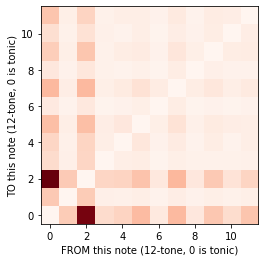

14037 in cluster, max distance = 0.45610547078331437
0.05 DJ Jeroenski: Back Once Again (Vandalism Remix)
0.05 Ashley Gearing: Ode To Billy Joe
0.05 Flexa Lyndo: OBI
0.05 Blue Sonix feat. Gary Bardouille: Understand
0.05 Lieutenant Pigeon: Mouldy Old Dough
0.05 The Pearlfishers: Up With The Larks
0.05 Bullet: Gangsta Shit
0.05 Warrant: Mr. Rainmaker
0.05 Kasia Kowalska: Zyje Raz
0.05 Glamour To Kill: Endless Loop - Rock'n Roll


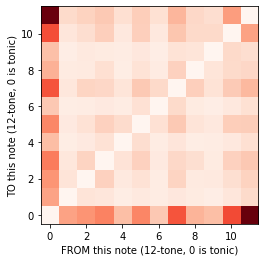

16515 in cluster, max distance = 0.2732217524425496
0.04 Jan Eggum: Mai Du Milde
0.04 I-20: Kisha
0.04 Martha & The Vandellas: If I Had A Hammer
0.04 Southland Gangsters: Down With Me
0.04 Titãs: Vamos Ao Trabalho
0.04 Dannii Minogue: True Lovers (12")
0.04 Woe of Tyrants: Fable Thy Destination
0.04 Josh Pyke: Buttons
0.04 Mistah F.A.B ft.E40_  Mac Dre_ Messy Marv_ Yukmouth_ Mac Mall_ Mr. Kee_ Various Otheres: Kicked Out The Club
0.04 Right Said Fred: Deeply Dippy (Single Mix)


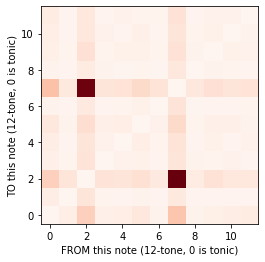

10710 in cluster, max distance = 0.515880363398144
0.04 Denis Leary: At The Rehab
0.05 Shockabilly: Dang Me
0.05 Simple: Outro
0.05 Fred Fortin: Massacre à l'harmonica
0.05 Mercanti Di Liquore: Il suddito peggiore
0.05 Nick Cave & The Bad Seeds: Spell
0.05 Art Mengo: Le Même Tango
0.05 Tommy Womack: The Replacements
0.05 Giraldo Piloto - Klímax: La chica perfecta
0.05 Bo Diddley: Kids Don't Do It


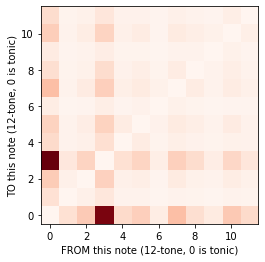

9276 in cluster, max distance = 0.9112662340295679
0.05 The Bar-Kays: In The Hole
0.05 Leonard Santic All Stars: Problems #2
0.06 Brunning Sunflower Blues Band: Outro - Sunflower Shuffle (excerpt)
0.06 The Blues Band: The Grass Is Greener
0.06 Billy Talent: Covered In Cowardice (Album Version)
0.06 Small: Shaken Not Stirred
0.06 Enchant: Enchanted (acoustic) (bonustrack)
0.06 Israel Philharmonic Orchestra / Walter Weller: 2. Vltava (The Moldau)
0.06 Sam's: Vue d'en bas (feat. Khalid (les Lyricalistes))
0.06 Let 3: Armada


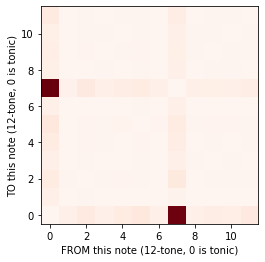

2834 in cluster, max distance = 0.8028613400794452
0.05 John Paul: Deuxième Livre (continued): La de Redemond
0.05 Airbase: Denial
0.05 Domu: Arrival
0.05 Boy Hits Car: This Song For You (Album)
0.05 Duster: QC Girls
0.06 La Quinta Estacion: Que Te Queria
0.06 FM Einheit: Hammermörder
0.06 High Rising: Problem
0.06 Nappy Roots: Roll Again (Explicit)
0.06 DJ Shah: Back To You


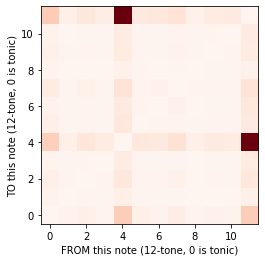

1918 in cluster, max distance = 0.8579456253636221
0.05 Haberdashery: Carol Of The Bells
0.06 Polly Paulusma: Give It Back
0.06 Shira Kammen: Ce Moys de May
0.06 UNKLE: In A State
0.06 Lords Of The New Church: Girls Girls Girls
0.06 Floyd Dixon: Hole In The Wall
0.06 Key Of Life: Inner Silence
0.06 3LW: Never Let 'Em Go
0.06 Renée Fleming / London Voices / London Philharmonic Orchestra / Sir Charles Mackerras: Casta Diva
0.06 The Charlie Daniels Band: Renegade


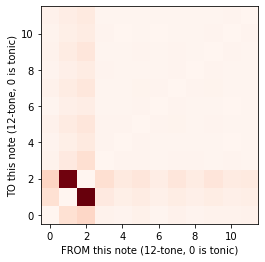

3159 in cluster, max distance = 0.8457997317864938
0.05 Zoegirl: Ordinary Day
0.05 S.Y.P.H.: Fiery Jack
0.05 Dannii Minogue: This Is It
0.06 Cinema Bizarre: Forever Or Never
0.06 Rusty Bryant: All Day Long
0.06 Lisa Lois: Smoke
0.06 Three Second Kiss: Deviationism
0.06 Los Traileros Del Norte: Quiero Que Vuelvas
0.06 Aaliyah: Back & Forth
0.06 The Bluegrass Cardinals: Just a Little Talk With Jesus


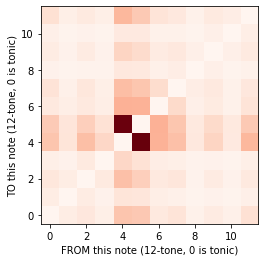

10581 in cluster, max distance = 0.44086566141684846
0.04 Upsilon Acrux: Expiration date (alaska_ my darkness)
0.04 The Hunches: Chainsawdomy
0.05 Red Elvises: Closet Disco Dancer
0.05 Barão Vermelho: Billy Negão
0.05 John C. Reilly: Who Wants To Party
0.05 Nelly: N Dey Say
0.05 Textures: Heave
0.05 Haley Bonar: Captain Captain
0.05 Swen Weber: Bassmann
0.05 Tom Hughes: 04 Daydream


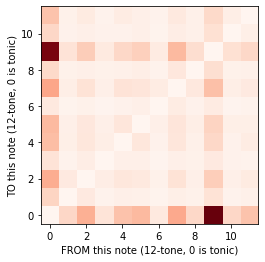

8469 in cluster, max distance = 0.9304269546019873
0.05 Elza Soares: O Porteiro me Enganou
0.05 Ebola: Survivor
0.06 Jose Julian: Te Conquistare
0.06 Doof: Double Dragons
0.06 The Soundtrack of Our Lives: Galaxy Grammophone
0.06 Adham Shaikh: Sub Bubble
0.06 Hank Thompson: Cryin' In The Deep Blue Sea
0.06 Sergei Prokofiev: Marche Op 12 No 1
0.06 Rasco: I Love Cali Part 2
0.06 James McMurtry: Melinda


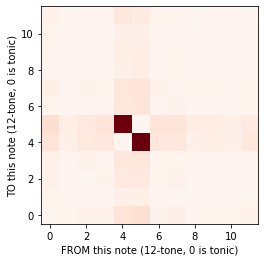

2846 in cluster, max distance = 0.8491414619256689
0.05 Hudba Praha: Hospoda
0.06 Califone: Funeral Singers
0.06 DZ: Paint By Numbers
0.06 Los Corraleros De Majagual: Sueltala Pa' Que Se Defienda
0.06 Rose Funeral: Redeemer Of Flesh
0.06 Bob Mould: Whichever Way The Wind Blows
0.06 Nadia Ali: Fantasy
0.06 Thin White Rope: Munich Eunich (Demo)
0.06 Mallorca Lee: Lets Go Back
0.06 Bleeding Through: My War (Bonus Track)


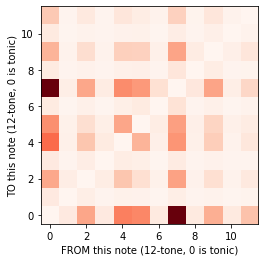

18006 in cluster, max distance = 0.28870228344266147
0.04 Death Breath: Chopping Spree
0.04 Belinda Carlisle: Feels Like I've Known You Forever
0.04 Javier Ruibal: Dama de mis días
0.05 Keimzeit: Getrennte Wege
0.05 Garnet Silk: Thankful
0.05 Jonathan Sherrill: Grandad
0.05 Moca: clarke boland
0.05 Living Colour: Ignorance Is Bliss
0.05 Christine Fellows: Afterword
0.05 Mint Royale: Sexiest Man In Jamaica (Acapella)


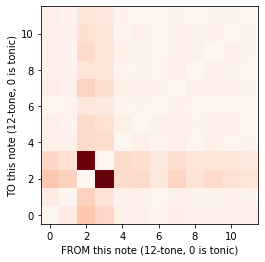

9730 in cluster, max distance = 0.5290835307462631
0.03 Dean Evenson: Floating To Forever
0.04 Hoodys: Every Hour
0.04 James Pants: Wash To Sea
0.04 Blind Joe Taggart: Scandalous And A Shame
0.04 Jose Fajardo: Salsa Maracucha - Original
0.04 The Pit That Became A Tower: True Transmitter Control Board (The Year Of Jubilee)
0.05 Michael Stuart: Nadie Sabe
0.05 Alexandre Pires: Usted Se Me Llevo La Vida
0.05 Rocio Jurado: Si Amanece
0.05 Copeland: On The Safest Ledge


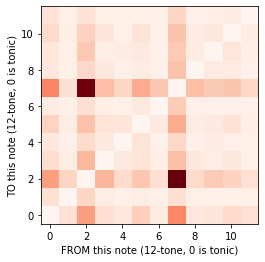

18709 in cluster, max distance = 0.3224651586980424
0.04 Jake Hess: White Christmas (Christmas A Time For Joy Version)
0.05 Milt Jackson: Chyrise
0.05 Plateau: Three Years
0.05 Illumination: 4 AM
0.05 Zacarias Ferreira: Te Necesito
0.05 Homer/Waitress/Lisa/Edna Krabappel/Marge: What Do I Think Of The Pie?
0.05 Molly Johnson: If You Know Love
0.05 Manzanita: Margarita
0.05 Onur Özer: 1996
0.05 Ruoska: Lihaa vasten lihaa


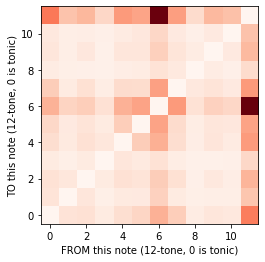

8184 in cluster, max distance = 0.5224120117498522
0.05 Vicky Leandros: Chilies Kai Mia Nichtes
0.05 New Order: World In Motion
0.05 Lord Est: Se on päätetty
0.05 Sam Punk & Weichei pres. Kanakk Attakk: Marijuana (Smoke That Shit)
0.05 Pru: Always waiting
0.05 Sluggy Ranks: Revelation
0.05 Will Easley: Damn Fool
0.05 Carbon Leaf: X-Ray
0.05 Louis Chedid: Papillon (Cirque Royal Bruxelles 2003)
0.05 Rhinoceros: Breaking Point


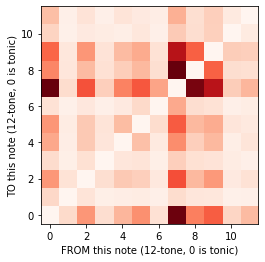

13530 in cluster, max distance = 0.33360810421843134
0.04 Everette Harp: Inner City Blues
0.04 Bell Biv DeVoe: Do Me!
0.04 Brand X: Algon (recorded 9-27-1979)
0.04 Adam Rickitt: Touch Me
0.04 Gilbert Bécaud: Un Peu D'amour Et D'amitiés
0.05 Ester Drang: Proustian Moments
0.05 Forest People: 1000 Miles To Heel
0.05 Ken Yokoyama: I Go Alone
0.05 Randy Brecker: Tijuca
0.05 Alex Kenji: stupid question


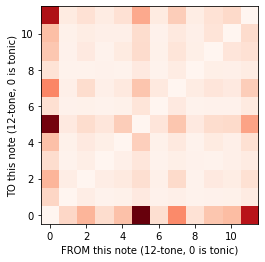

8694 in cluster, max distance = 0.40331202044760295
0.04 Al Denson: Love Is Taking Hold
0.05 Ah Cama-Sotz: Vio-lence And Vivi-section
0.05 Chambers Brothers: Rained The Day You Left
0.05 The Lemonheads: [Untitled]
0.05 Laura Welland: I'm Gonna Sit Right Down And Write Myself A Letter
0.05 Big Bang Theory: The Atrium
0.05 Alexander Robotnick: Dance Boy Dance
0.05 Teena Marie: You Blow Me Away
0.05 Montrose: Untitled
0.05 The Pacifics: Crosstown Classic (Featuring Larry Millah & Iomos Marad)


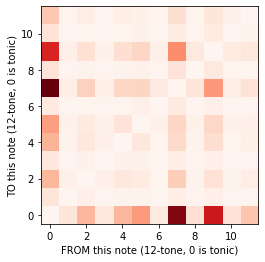

6586 in cluster, max distance = 0.44144288353578076
0.05 Tommy Page: A Zillion Kisses (LP Version)
0.05 K T Oslin: My Legionnaire
0.05 Everclear: Father Of Mine (Radio Mix) (2004 Digital Remaster)
0.05 The Rockingbirds: Only One Flower
0.05 George Lopez: You Saw Me
0.05 Debi Makhsoospuri: Tenu Kujh Ve Pata Nahin
0.05 Los Inquietos: Sólo amame
0.05 Riamiwo: everytime
0.05 Sonny Simmons: My Favorite Things (Album Version)
0.05 Danny Elfman: Market Troubles


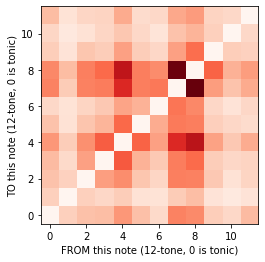

11049 in cluster, max distance = 0.9835234643236987
0.03 Whitney Houston: I'm Your Baby Tonight
0.03 Francis Dunnery: Sunflowers
0.04 Jhonny Rivera: Recuerdo a mi hijo
0.04 Planlos: Sorgenkind
0.04 Duran Duran: Hold Back The Rain (2001 Digital Remaster)
0.04 Les Philippes: Citizen Of Oz
0.04 Suicide: Keep Your Dreams (Live At CBGB's)
0.04 Charlie Mole: The Interview
0.04 Carmen Y Laura: La Torcida
0.04 Machine Head: The Frontlines (Album Version)


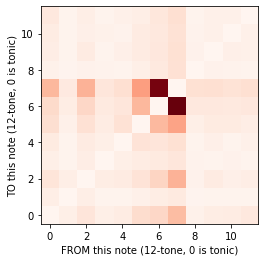

14279 in cluster, max distance = 0.6550873207524672
0.04 Law: The One
0.04 Till Brönner / Chris Botti / Dominic Miller: Notes On Snow
0.05 Mino Reitano: Innamorati
0.05 Solange: T.O.N.Y.
0.05 Pink Money: The Way
0.05 Ayleon: Lost Sign
0.05 The Boomers: What Can Love Do
0.05 Las Niñas: Cuento De La Buena Pipa
0.05 House Of Pain: Danny Boy_ Danny Boy (LP Version)
0.05 Ferrante & Teicher: Stephen Foster Fantasy


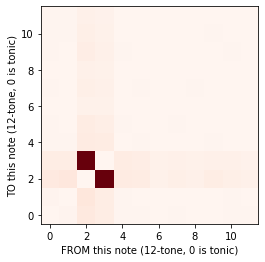

1573 in cluster, max distance = 0.7918340902332192
0.04 Il Parto Delle Nuvole Pesanti: Philippe petit
0.04 Dave Barnes: Carry Me Through
0.04 Sebastian Krämer: Der Lebensmüde Specht
0.05 Victoria Abril: Mes Hommes
0.05 Gagle: Night Moves (Original)
0.05 Kira: Cold Sweat
0.05 Harry Gregson-Williams: Setting Sail
0.05 Blasphemy: Blasphemy (Demo Version)
0.05 Muzzaik: I Feel You (Original Mix)
0.05 Cantina Sociale: Kantele


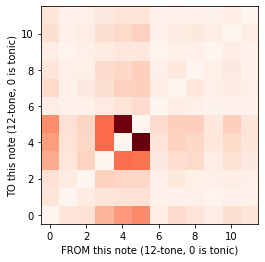

7376 in cluster, max distance = 0.46367890308304
0.04 Charlie Mole: Importance Of Being Earnest Front Titles
0.05 The Jackson Sisters: When God Is In The Building
0.05 The Solid Doctor: Dusk
0.05 Quarteto Em Cy: O Circo
0.05 Seefeel: Charlottes Mouth
0.05 Tree: Real
0.05 Unruly Child: Vertigo
0.05 Hanoi Rocks: Futurama
0.06 Geri X: Strangers
0.06 The Beloved: Deliver Me


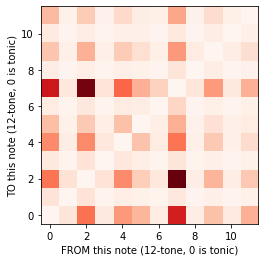

16312 in cluster, max distance = 0.31502936970730944
0.04 Warrant: Love In Stereo
0.04 Tanya Stephens: I Am A Woman
0.04 Psykick Lyrikah: L'éclair (feat. Gaël Desbois)
0.04 STEVE TAYLOR: Bad Rap (Who You Tryin To Kid_ Kid?)
0.04 MC Solaar: Lève-toi et rap
0.05 Lynden David Hall: Where's God?
0.05 Carpe DM: Love is Strong
0.05 LTN: A Simple Plan
0.05 Tipsy: Size 178-79-55-91
0.05 Charlie Rich: A Satisfied Man


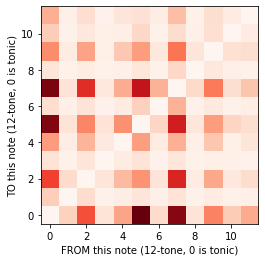

20812 in cluster, max distance = 0.2356762066662591
0.04 Leona Naess: Unnamed
0.04 Niels Frevert: Niendorfer Gehege
0.04 Ranking Dread: Love A Dub
0.05 Jason Fioto: Get To You
0.05 Bigbang: Wild Bird (live)
0.05 Killa Kyleon_ Lil Boss_ Lil C_ & OG Avery: Get Out These Streets
0.05 Bo Kaspers Orkester: En Dag Att Bli Kär På
0.05 Andy Yorke: Let It Be True
0.05 Subway Sect: Derail Your Senses
0.05 The Regiment: Changes


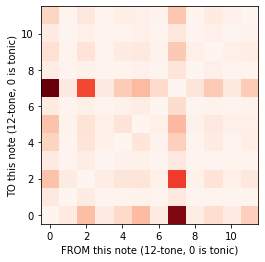

13337 in cluster, max distance = 0.25442221475170596
0.05 Zero Assoluto: Sei parte di me
0.05 Glory & Shame: I Am Here
0.05 Jon Auer: Green Eyes
0.05 Laurent & Lewis_ Aaron-Carl: Motion (Le Club Cuisine Karaoke Mix)
0.05 Seu Jorge: Mariana
0.05 Dead Ant Farm: Broken Heart Song
0.05 Stationary Odyssey: Uh
0.05 Entombed: Eyemaster
0.05 Kimen: Yep
0.05 Waxies Dargle: Urban Cycle


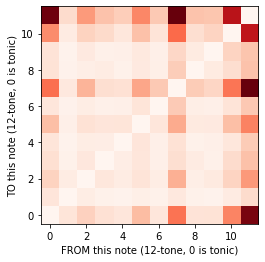

8714 in cluster, max distance = 0.42004423420976666
0.05 Irma Thomas: It's Raining (2002 Digital Remaster)
0.05 Will Ackerman: Sound Of Wind Driven Rain
0.05 Rhian Sheehan: Scene 6
0.05 Psychedelic Horseshit: Portals
0.05 Con Dolore: Keeper
0.05 Onyx: Faithful Love
0.05 The J. Geils Band: I'll Be Coming Home (LP Version)
0.05 Johnny Clegg & Savuka: Warsaw 1941
0.05 P J Proby: Suburban Opera
0.05 CANDLEMASS: Samarithan


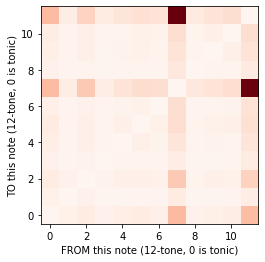

4676 in cluster, max distance = 0.8977418983482774
0.04 Duncan Dhu: Siempre (al abandonarnos) - album
0.04 George Acosta: Fallin Backwards
0.06 Claude Ciari: Balad El Mahboub
0.06 Meiway: Mami (feat. Lynnsha)
0.06 Slumber Party: Why Do I Care
0.06 Dianogah: Eucalyptus
0.06 Lucinda Williams: Right In Time
0.06 Three Drives: Air Traffic
0.06 Boris Gardiner: The Meaning of Christmas
0.06 Alove For Enemies: Hall Of Mirrors


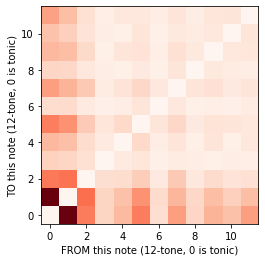

19911 in cluster, max distance = 0.9956640046888972
0.04 Airiel: Halo
0.04 Mr. Lil One: Dangerous Mind
0.04 Suicide: Abortion
0.04 Mary Has A Little Lamb: On The Run Again
0.04 Spanky & Our Gang: Lazy Day
0.04 Katerine: Shut Your Mouth (Daniel Bovie Short)
0.04 Alcazar: Salmone
0.04 Gene Ammons: New Sonny's Blues
0.04 Bob The Builder: Halfway Down The Hill
0.04 Lesley Garrett: You'll never walk alone


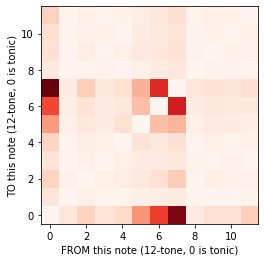

5228 in cluster, max distance = 0.5200774711558759
0.05 Maroon 5: Until You're Over Me
0.05 Claw Boys Claw: Probably
0.05 Ewan MacColl: Sir Patrick Spens - Child 58
0.05 The Candy Snatchers: Sympathy Trip
0.05 Four Year Strong: Beatdown In The Key Of Happy
0.05 Luca Dirisio: Niente E' Perso
0.05 Guasones: Estupendo Día
0.05 Robert Belfour: I'm Gonna Leave You
0.05 Kaizers Orchestra: Die Polizei
0.05 Echo Is Your Love: Minor Flirt


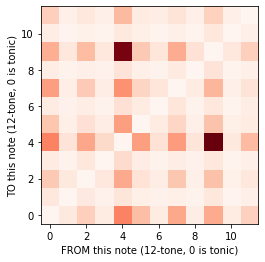

6776 in cluster, max distance = 0.9460094011286119
0.04 Mark Mothersbaugh: Extreme Volcano
0.05 Nerina Pallot: God
0.05 Nick Haeffner: The Earth Movers
0.05 Orquesta Sonara La Habana: Guaguanco Napoleon
0.05 Between The Buried And Me: B. Anablephobia (Album Version)
0.06 Duke Ellington_ His Famous Orchestra: The Wonder of You
0.06 Slick Shoes: Losing Sight
0.06 Jimmy Smith: When Johnny Comes Marching Home
0.06 Bellamy Brothers: Old Hippie
0.06 Funky Transport: the bedford files


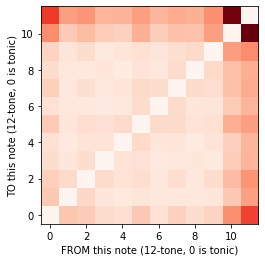

12727 in cluster, max distance = 0.9941639725753554
0.03 Wednesday 13's Frankenstein Drag Queens From Planet 13: Die My Bride (Album Version)
0.04 Stefan Gwildis: Wo bist du grad
0.04 Duke Ellington: Lazy Rhapsody
0.04 Frank Chacksfield And His Orchestra: Victory At Sea
0.04 Sash!: Stay 
0.04 Benny Green: Billy Boy (Live)
0.04 Charanga de la 4: Bonito y Sabroso
0.04 D.O.A.: Rent a Riot
0.04 The Waterboys: High Far Soon (2004 Digital Remaster)
0.04 Bugz In The Attic: Redhanded


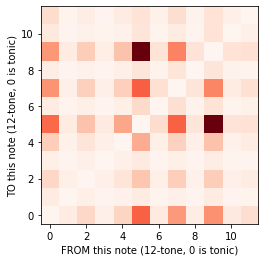

4038 in cluster, max distance = 0.5462096933568796
0.04 Waylon Jennings: Abilene
0.05 Amel Larrieux: Weary (Album Version)
0.06 Holly Williams: Everybody's Waiting For A Change
0.06 The Shadows Of Knight: Bad Little Woman (LP Version)
0.06 Anthony B: Vanity
0.06 Gladiators: Bellyfull (2000 Digital Remaster)
0.06 Wedding Present: Red Shoes By The Drugstore
0.07 Grateful Dead Tribute: Cumberland Blues
0.07 Nurettin Colak: What Happened
0.07 Koko Taylor: Wonder Why


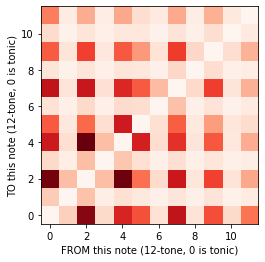

25225 in cluster, max distance = 0.2930305761726947
0.04 The Count Bishops: Shake Your Moneymaker
0.04 Bruce Springsteen: Secret Garden
0.04 D-Code_ Ben Herman: The Third Way Out
0.04 Anastacia: Club Megamix
0.04 Too Strong: Tage Wie Dieser
0.04 Majestic: Poison
0.04 Blind Willie Johnson: If I Had My Way I'd Tear the Builing Down
0.04 Larry Vuckovich: Lester's Minor Blues (Larry Vuckovich original suggests Lester Young's melodic and smooth rhythmic phrasing.)
0.04 The Motes: Argot
0.04 Gordon: Alleen Om Dit Moment (edit)


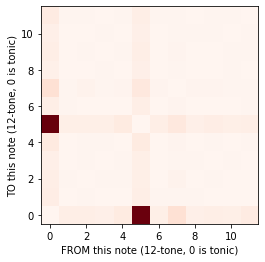

1699 in cluster, max distance = 0.808595292500853
0.04 Dof: My Pheonix
0.06 Male Or Female: They Looked Like Fire
0.06 The Matthew Herbert Big Band: The Many And The Few
0.06 Phobia: Never
0.06 Broken Social Scene: Backyards
0.06 Flyleaf: Treasure
0.07 Giovanni Allevi: Le Tue Mani
0.07 Bad Habit Boys: King Of Trash (Single Mix)
0.07 PPFC: L'insatisfait
0.07 Ronski Speed with Stoneface & Terminal: Incognition


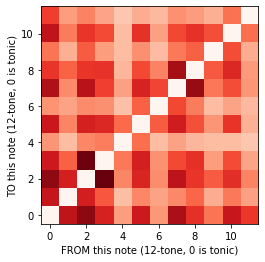

35203 in cluster, max distance = 0.4776665972638673
0.03 Melys: Chinese Whispers
0.03 Julie Andrews: Do I Love You Because You're Beautiful
0.03 Matthew Barber: Sentimental Acumen
0.03 Slim Smith: Love And Devotion
0.03 Ozma: Your Name
0.03 Scarlett Johansson: Fawn
0.03 La Habitacion Roja: Aquellos Maravillosos Años
0.03 Unleashed: As Yggdrasil Trembles
0.03 The Lash Outs: Requiem For Rock and Roll
0.03 Paper Rival: The Family Ghost (Album Version)


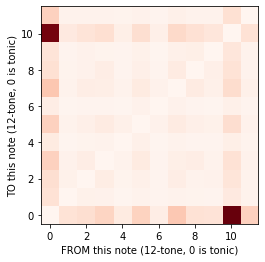

4672 in cluster, max distance = 0.8980985217488645
0.05 Pentagram: Behind The Veil
0.05 Superheist: A Dignified Rage
0.05 Leslie Mendelson: I Know You Better Than That (Album Version)
0.06 Smokin' Jo: Tribal Badman
0.06 Jesca Hoop: Feast Of The Heart
0.06 Low Low Low La La La Love Love Love: Rest Your Arms
0.06 Mainstay: Where Your Heart Belongs (Key-E-Premiere Performance Plus w/o Background Vocals)
0.06 Johnny Paycheck: Something About You I Love
0.07 Zana: Rane
0.07 Wilt: Painting Sound Into Futurism


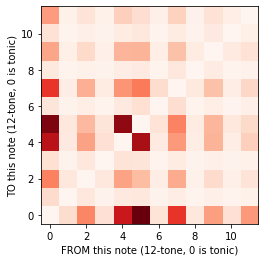

14599 in cluster, max distance = 0.3475639826948706
0.05 Los Del Mar: El Mueve Mueve (feat. Josè Garcia)
0.05 Immaculate Fools: Pretty Prize Now
0.05 Camélia Jordana: Lettera
0.05 Descendents: Anchor Grill
0.05 Korea: It's Over
0.05 Alan Silvestri: This Night Is Their Last
0.05 4Him: Measure Of A Man
0.05 T-Bone Walker: West Side Baby
0.05 Duke Pearson: Rotary (2006 Digital Remaster)
0.05 Effcee: Digital World


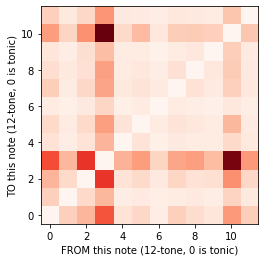

6354 in cluster, max distance = 0.5967157889830306
0.05 Patent Pending: The Old Country Church
0.05 Hawkwind: Alien (1 AM)
0.05 Angela Dimitriou: Ime Gineka Tou Kefiou
0.05 The Runaways: I Want To Run With The Bad Boys
0.05 Leroy Hutson: You're A Winner - Original
0.05 The Heavy: The House That Dirt Built
0.05 Lil' Zane: Too Hot To Stop
0.05 Joao Donato: It Didn't End (Nao Se Acabou)
0.06 Hurst Pier Point: Under Fire
0.06 Bernward Koch: Playing Children


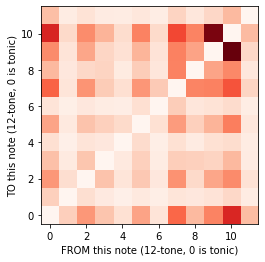

12005 in cluster, max distance = 0.5392647166664397
0.04 Thomas Dolby: I Scare Myself
0.05 Lake Trout: Pill
0.05 Blacklisted: Wish
0.05 Tony Sheridan: Four Day Working Week
0.05 Link Wray & The Wraymen: Dixie-Doodle
0.05 Gillie Da Kid: Murder Murder Kill Kill Homicide
0.05 Lotte Lenja : Moritat/Schlusschoral/Moritat/End Chorale
0.05 The Gathering: The Earth Is My Witness
0.05 Frankie: Narcotica Baby
0.05 Glen Glenn: Companys Comin


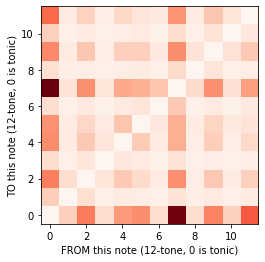

25554 in cluster, max distance = 0.23273785819941886
0.04 KC And The Sunshine Band: Do It Good
0.04 Los Rebeldes: No Quiero Verte
0.04 Juvenile / Jay-Z: Ha
0.04 Microspasmi: Se voi ci capireste feat. Bassi Maestro
0.04 Capoeira Twins: Propane
0.04 Gogi Grant: Golden Ladder
0.04 The Gaskets: The Best Thing
0.04 Elf: Alleine in Nirvana
0.04 Los Piratas: Promesas 98
0.04 Down By Law: Surrender


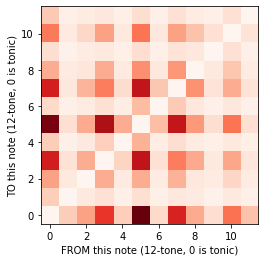

19182 in cluster, max distance = 0.34000835929673645
0.04 David deMaria: Pa cuando necesites que yo este
0.04 Gary Hobbs: Desde La Raiz
0.05 Kitchens Of Distinction: Glittery Dust
0.05 Britney Spears: Mmm Papi
0.05 Bienvenido Granda: Ven Pollito - Original
0.05 Dictafone: 10 moons rising
0.05 DeGarmo & Key: Out Of The Danger Zone (Degarmo And Key Album Version)
0.05 Brenda Holloway: (You Can) Depend On Me
0.05 Margo Smith & Holly: When The World Turns On Me
0.05 Slapp Happy: Moon Lovers


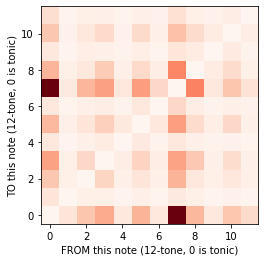

19648 in cluster, max distance = 0.36013971373719744
0.05 Manuel Escacena: Nada una dama
0.05 Robin Williamson: By Weary Well
0.05 Rock Plaza Central: (Don't You Believe the Words Of ) Handsome Men
0.05 KC And The Sunshine Band: I Like To Do It
0.05 Strauss: Ouverturevalses De Vienne Act1
0.05 Tito El Bambino: Bailarlo
0.05 Levellers: Wild As Angels
0.05 Simple Plan: How Stuff
0.05 Kali: Kali Dous
0.05 Capleton: Make a try


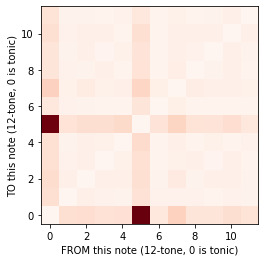

10884 in cluster, max distance = 0.519137251747313
0.05 Penumbra: Cursed Destiny
0.06 Zadera: You
0.06 Italian Instabile Orchestra: Du Du Duchamp [Skies of Europe]
0.06 Black Debbath: Bunad (The National Costume)
0.06 Dan Sartain: Got That Feeling
0.06 Ziggy Marley And The Melody Makers: Wrong Right Wrong
0.06 Sviatoslav Richter_ Franz Schubert: Impromtu No. 2 in A-Flat Major_ Op. 142
0.06 Astrix: Eye to Eye
0.06 Morgana King: A Song for You
0.06 Gene Vincent: Say Mama


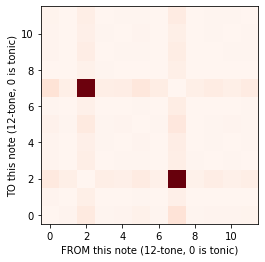

2130 in cluster, max distance = 0.8104876101002905
0.05 Colombia Alegre Y Romantica: La Casa En El Aire
0.06 Elvis Costello: Hoover Factory
0.06 Solarscape: Alive
0.06 Beat Dominator: Bassik Instinkt
0.06 The Bristols: Baby You're Phrasing is Bad
0.06 Bikstok Røgsystem: Tjikkah
0.06 Gary Burton: Invierno Porteno
0.06 Ludovico Einaudi: Ever
0.06 Seigmen: Nemesis
0.06 Voyager One: Praise The Lowered


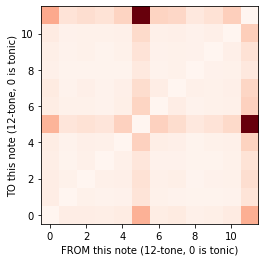

3598 in cluster, max distance = 0.9141070670585814
0.05 Patrick Rondat: Amphibia Part 1
0.06 Little Junior Parker: Look on Yonders Wall
0.06 Eric Demarsan: L'ombre d'une chance
0.06 Tyson: Freedom Roc
0.06 Robert Shaw: Dirty Duckins #1
0.06 Duraluxe: Lowly Creatures
0.06 The Raspberries: Starting Over
0.06 Sinister Street: Thin Ice
0.06 Paolo Nutini: Rewind (PSILY Album Version)
0.07 Smokie: Don't Play Your Rock 'n' Roll To Me


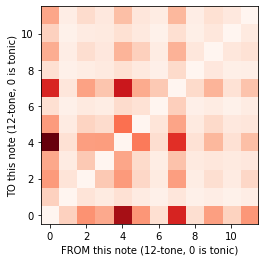

19978 in cluster, max distance = 0.32435086866174345
0.04 Beatriz Adriana: Que no me faltes tu
0.04 Scienz of Life: Comminion (Interlude)
0.04 Slim Lamar and his Southerners: Goofus
0.04 Chingo Bling: Pain In My Huevos (Chopped & Screwed Version)
0.04 Transfer: Get Some Rest
0.04 Javier (Featuring Luna): Dance For Me - The Reggaeton Remix
0.04 The Wolfgang Press: Bottom Drawer
0.04 The Caroloregians: Working Class Stomp
0.05 Sascha Heyna: Ich bau Dir ein Himmelszelt
0.05 Johnnie Ray: Cry


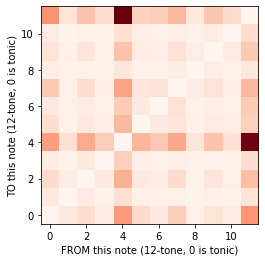

12054 in cluster, max distance = 0.430868943128268
0.04 Sporto Kantès: Da Rock
0.04 Horace Silver: Silver Threads Among The Soul (Rudy Van Gelder Edition) (1999 Digital Remaster)
0.05 Rusty York: Sugaree
0.05 The Brady Bunch / Marsha Brady: Away In A Manger
0.05 Stuck Mojo: Southern Pride
0.05 Behemoth: Pazuzu
0.05 Michael Mantler: Vanità [Part 3]
0.05 Twinkle Twinkle Little Rock Star: Closer (made famous by Kings Of Leon)
0.05 The Get Up Kids: Never Be Alone
0.05 Sandra Sá: Vale Tudo


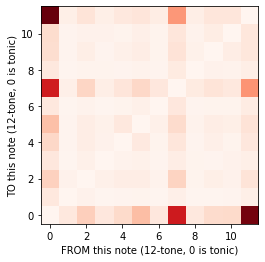

8511 in cluster, max distance = 0.398365286945668
0.05 Edith Lefel: Mon ange
0.05 Yahel: Liquid Love
0.05 Lesley Gore: She's A Fool
0.05 Xzibit: Paul
0.05 Mötley Crüe: Live Wire
0.05 Puffball: Barracuda
0.05 Kaada: Marja Dalia_ The Polska Bogini
0.06 Joe Christmas: Dreaming For The Gold
0.06 Mad and Spectral: Shine For Me
0.06 Hemdale: Pus-Filled Carcass


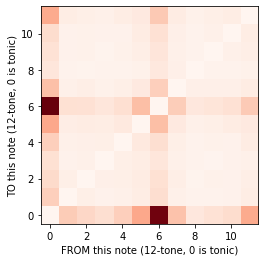

4511 in cluster, max distance = 0.9238358507132807
0.05 Venetian Snares: Mentioning It
0.05 Grave: Christi(ns)anity
0.06 The Pinker Tones: Maybe Next Saturday
0.06 Five Blind Boys of Alabama: Fix It Jesus
0.06 Thomas Godoj: Love Is You
0.06 Frog Pocket: Vaedre
0.06 The Scientist: Style And Pattern
0.06 Cali Agents: Real Talk
0.06 Bluesmasters Featuring Mickey Thomas: Cherry Red
0.06 The Congos: Lion In The Jungle


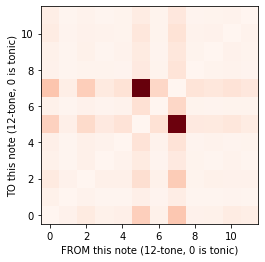

7010 in cluster, max distance = 0.6337755934860466
0.05 Carlene Davis: Walk the Walk
0.05 Lush: Demystification
0.05 Charles Fambrough: Save That Time
0.05 Cassius Clay: Round 5:  Will The Real Sonny Liston Please Fall Down
0.06 Quietdrive: We Believe
0.06 At War With Self: Torn Between Dimensions
0.06 Chamberlain: Better Ways
0.06 Aled Jones: The Sussex Carol
0.06 Little Pieces: Stop The World
0.06 McNastee: What More Do You Want From Me


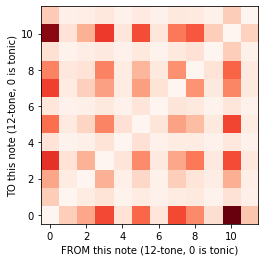

20491 in cluster, max distance = 0.5344092066842808
0.04 Neil Diamond: New York Boy
0.05 These New Puritans: We Want War
0.05 El Poder del Norte: El niño y la boda
0.05 Harry Lauder: Wee Hoose Among The Heather
0.05 Indidginus: Extinction
0.05 Gabriel Gordon: Find A Way
0.05 Everest: Reloader (Album Version)
0.05 Chokebore: Days Of Nothing (Full Band Winter Version)
0.05 Oscar G: Back To You (Stryke and Quik Zipper Mix)
0.05 Edvin Marton: Bellydance


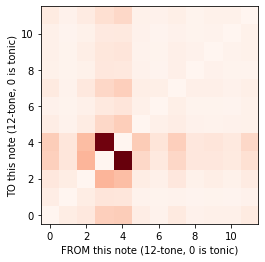

5574 in cluster, max distance = 0.9099919970668834
0.05 Ross Copperman: I Get By
0.05 Alex Band: Tonight (Single Mix)
0.05 4 Clubbers: Sonar 2 (Club Mix)
0.05 Sammi Cheng: Ru Guo Wo Men Bu Zai Jian
0.06 Giraffe Running: Piss Off Back To Nottingham (w. Bryn Cloke - MONTANA PETE)
0.06 Carl Perkins: Matchbox
0.06 Frankie Bones: This Is The Dance (Original Mix)
0.06 Soft Cell: Tainted Love
0.06 D'Molls: The Answer (Album Version)
0.06 Buzzcocks: Jesus Made Me Feel Guilty (Demo)


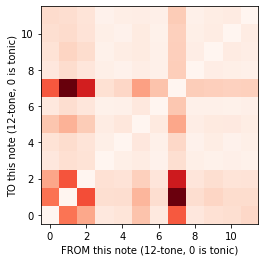

6775 in cluster, max distance = 0.9556200465883165
0.05 Our Lady Peace: Denied
0.05 Matt Pond PA: Brooklyn Stars (Album Version)
0.05 Amber: This Is Your Night
0.05 Television Personalities: If I Should Fall Behind
0.05 Big Daddy Weave: When I See You (LP Version)
0.05 Kool Moe Dee: How Kool Can One Blackman Be
0.05 León Gieco: La Navidad De Luis
0.05 Bjørn Svin: Banjuglen #1
0.05 Tommy Hunt: Don't Let This Be Our Last Love Song
0.05 The Datsuns: Too Little Fire


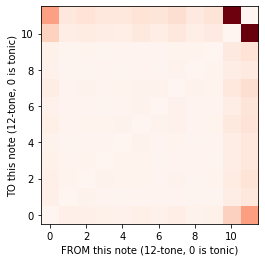

2937 in cluster, max distance = 0.8750394897499172
0.04 Renee Rosnes: Empress Afternoon
0.04 The Acacia Strain: Predator: Never Prey
0.05 Goldie Hill: Treat Me Kind
0.05 Kathleen Madigan: Sports (Album Version)
0.06 Second Silence: Incensurable
0.06 THE CHIFFONS: A Love So Fine
0.06 Late Night Sneaky & Dave Coleman feat. Janaysa: Love Train
0.06 Fred Simon: Listen To The Colour Of Your Dreams Pt 1
0.06 Dany Dan: Plus de confiance (feat. Hayadi)
0.06 Port O'Brien: Will You Be There?


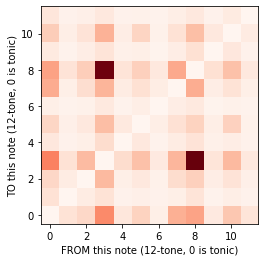

9829 in cluster, max distance = 0.9427636178832263
0.05 Otis Taylor: Ain't No Cowgirl
0.05 Erik Darling: Merry Christmas
0.06 Helen Reddy: Leave Me Alone (Ruby Red Dress)
0.06 Josef Locke: Charmaine
0.06 The Haunted: Shake
0.06 Loves Ugly Children: Junkfood
0.06 Julie Doiron: I Love To Dance
0.06 Jungle Rot: Symbols of Hate
0.06 Benjamin Biolay: Si tu suis mon regard
0.06 Lene Alexandra: My Boobs Are Ok (Original)


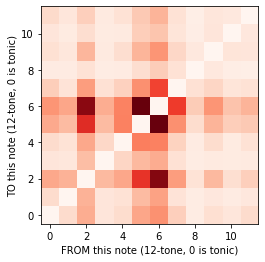

13477 in cluster, max distance = 0.7080433058646753
0.04 Été 67: On nous cache tout_ on nous dit rien
0.04 Che guevara: Tribute to Antonio Maceo_ December 7_ 1962
0.04 East Side Beat: Ride Like The Wind
0.04 Giant Drag: White Baby
0.04 Eisregen: Zauberelefant
0.04 Slim Dusty: The Pub That Doesn't Sell Beer
0.04 22-20s: Why Don't You Do It For Me? (Single Version)
0.05 Ravi Shankar: Bhimpalasi
0.05 Skitsystem: Stars & Stripes = Scares & Strife
0.05 Logh: Ahabian


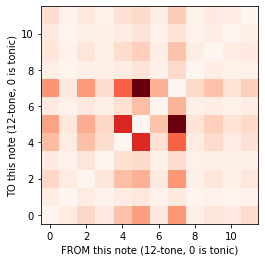

10100 in cluster, max distance = 0.4885640243131361
0.05 Show Of Hands: Innocents' Song
0.05 Sean Paul: Baby Boy [feat. Beyonce]
0.05 The Marvelettes: No Time For Tears
0.05 Ham Sandwich: Keepsake
0.05 Pinchers: Hide from yourself
0.05 Screaming Mechanical Brain: Praise
0.05 Less Than Jake: Nervous In The Alley
0.05 The Winans: J-E-S-U-S
0.05 Coffin Break: Rosey Picture
0.05 James Blunt: I Really Want You  (Acoustic Version)


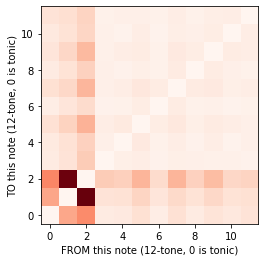

13110 in cluster, max distance = 0.4576465820819673
0.04 The Ike Reilly Assassination: The Nighttime Is A Liar (Album)
0.04 The Puppetmastaz: Do The Swamp
0.05 Necrophagist: Mutilate the Stillborn
0.05 Frank Chacksfield  Orchestra: The Last Time I Saw Paris
0.05 Malvina Reynolds: The Little Mouse
0.05 Lewis Taylor: Keep Right On Pop Version
0.05 Salomé De Bahia: Copacabana
0.05 Tribute Mega Stars: Break Your Heart  (Taio Cruz Cover Version)
0.05 George Acosta: Da Phunky Filler
0.05 Dr. Dre: Bar One


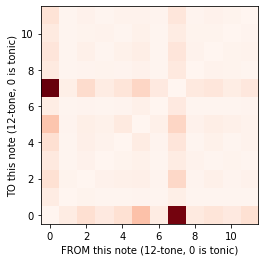

13038 in cluster, max distance = 0.3826208261442014
0.05 Bratz: Ready To Roll
0.05 Alejandra Guzman: Mirala_ Miralo
0.05 Brand Nubian: Grand Puba_ Positive And L.G. (Explicit LP Version)
0.05 LCD Soundsystem: Give It Up
0.05 Marumari: Meltdown of Earth
0.05 Toro Y Moi: Lissoms
0.05 Kelly Price: You Make Me Feel
0.05 Lovespirals: Treading the Water
0.05 Inspiral Carpets: Sleep Well Tonight
0.05 Wesley Willis: Dave Grohl


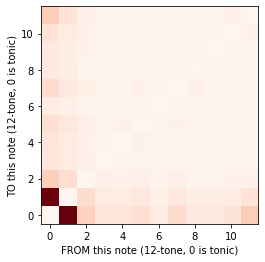

5852 in cluster, max distance = 0.8759889631901628
0.05 Ritchie Valens: We Belong Together
0.05 Hoots & Hellmouth: Home In A Boxcar (Album Version)
0.05 Hardcore Superstar: Lesson In Violence
0.05 DKMA presents Andrastea: Herdsman
0.05 Eko Fresh feat. Tha Outlawz: Bis ich unter der Erde lieg
0.05 Maria Muldaur: Heart Of Fire (LP Version)
0.05 I.M.P: Let Your Hoe Go
0.06 Telepopmusik: Tittsworth Remix
0.06 Marianne Rosenberg: Liebe 122
0.06 The Supersuckers: Teenage Shutdown


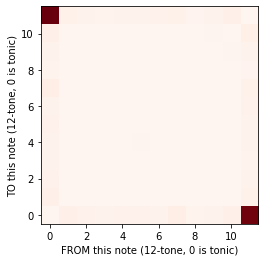

1440 in cluster, max distance = 0.7547616603099114
0.03 Alan Jackson: Don't Change On Me
0.04 TYR: A media luz
0.04 Jamal: Pull Up (Radio Edit)
0.04 David Usher: Closer
0.04 Every Avenue: Trading Heartbeats (Album)
0.04 Åsne Valland Nordli / Kristin Skaare: O_ Helga Natt
0.04 Orchestra Baobab: Beni Baraale
0.04 Royal Gigolos: Somebody's Watching Me
0.04 Klaus Badelt: Under Covers
0.04 Foxx: Wuck Ya


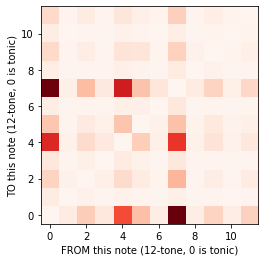

5563 in cluster, max distance = 0.5117412268938315
0.05 The Mother Goose Singers: Pinocchio
0.05 Perry Como: Sleepy Time Gal
0.05 DJ SD: Bad Girls (feat. Esther Adams)
0.05 Alex Megane: I think of you
0.05 Charlie Hall: Waking Up (On The Road To Beautiful Album Version)
0.05 Clarence Reid: Till I Get My Share
0.05 Duo Live: We Out Here
0.05 James Moody: Cherokee
0.06 Hushabye Baby: So Small (Lullaby Rendition of Carrie Underwood)
0.06 Trace Adkins: It Was You


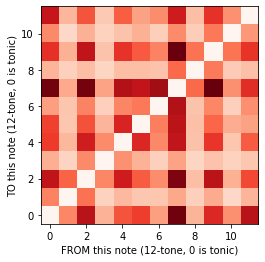

34697 in cluster, max distance = 0.31869408482409733
0.03 Martha Reeves & The Vandellas: Come And Get These Memories
0.03 The Smooths: 78th Of Soon
0.03 Kate Wolf: Pacheo/Redtail Hawk (Live Version)
0.03 David Rose: I'll Be Seeing You
0.04 Elmo Williams & Hezekiah Early: Booster
0.04 Shearwater: Mountain Laurel
0.04 Taras: I Will Love Again (Electric Soul Mix)
0.04 Genesis: Driving The Last Spike (Live)
0.04 The Bill Gaither Trio: Joy Comes In The Morning
0.04 Mario Lanza: And This Is My Beloved [from 'Kismet']


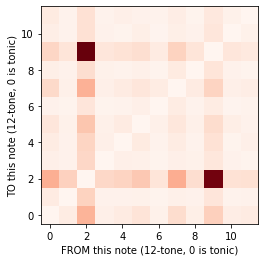

7780 in cluster, max distance = 0.6485762833151254
0.05 Paulinho Da Viola: Jurar Com Lágrimas (1995 Digital Remaster)
0.05 Cristal Snow: China Cool
0.05 Safi Connection: D Prophecy
0.05 Khan: Favor After Favor
0.05 Phil Keaggy: Inseperable (LP Version)
0.06 Mack and Jamie: All Gay Army
0.06 Time Has Come: Keep Your Tongue From Evil
0.06 Les Choeurs De L'Armée Rouge (Alexandrov): Soldats_ Garçons Braves - Soliste : E. Tsekinovski
0.06 Jack Off Jill: Cumdumpster
0.06 Sayag Jazz Machine: U Cil' Cut (Mélancholia Mix)


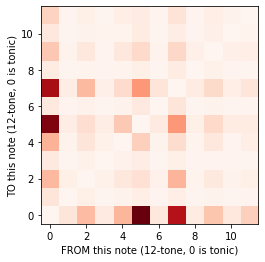

14135 in cluster, max distance = 0.513217565851096
0.05 Midlake: We Gathered In Spring
0.05 Jamie Richards: I Just Can't Love You Anymore
0.05 The Glorious Unseen: The Hope That Lies In You
0.05 Nacho Vegas: Actos Inexplicables
0.05 Students: Everyday Of The Week
0.05 Karyn White: The Way You Love Me (LP Version)
0.05 Bill Doggett: Eleven O'Clock Twist
0.05 Graciela Beltrán: Que Me Entierren Con La Banda
0.05 Die Sekte: Sekte Gang feat. Fuhrman_ Bendt_ Alpa Gun_ B-Tight
0.05 Noize Suppressor: Pass Me (Endymion Remix)


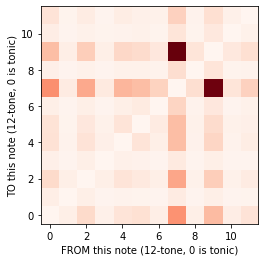

5018 in cluster, max distance = 0.9247840963106991
0.05 Yamboo: Come With Me (Bailamos)
0.05 Smashing Orange: Only Complete In You
0.06 Lucero: Darby's Song
0.06 Reckless Kelly: The Ballad of Tommy and Marie
0.06 Rolfe Kent: I Lost My Way
0.06 Symphony X: Smoke And Mirrors
0.06 Trilok Gurtu: Returning Home
0.06 Ljiljana Petkovic Orchestra: Das Ende der Welt
0.06 Sandy Lam: Wei Liang
0.06 Azure Ray: I Will Do These Things


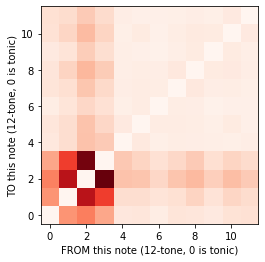

8381 in cluster, max distance = 0.6927468417164193
0.04 Dredg: Astronomy Domine
0.05 Jossie Esteban y La Patrulla 15: El Carino Es Como Una Flor
0.05 Benjy Davis Project: The Rain (Album)
0.05 Twig: Traffic
0.05 Wardian: Kowloon
0.05 Billy Joel: Goodnight Saigon
0.05 Radioactive Man: Lungfull of bass
0.05 Boyz II Men: Who Would Have Thought
0.05 Ray Brown Trio: Bam Bam Bam
0.05 Nino Nardini: Tango Rapsodie


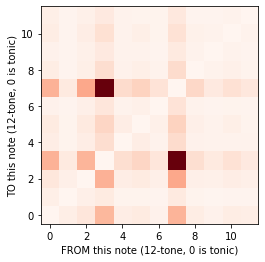

2844 in cluster, max distance = 0.91215900675969
0.05 Dionne Warwick: I Got Love (LP Version)
0.06 Michael & Levan_ Stiven Rivic: Croatia
0.06 Metallica: Of Wolf And Man
0.06 S.H.O.K.K.: Renaissance - Original Mix
0.06 Drake Bell: Somehow
0.07 Basement Jaxx: Good Luck (Album Version)
0.07 Al Jarreau: Aladdin's Lamp (LP Version)
0.07 Johnny Rawls: I'll Be Alright
0.07 Jerry Rivera: Las Alas De Mi Corazón
0.07 The Commitments: Mr. Pitiful


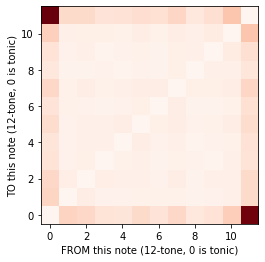

14460 in cluster, max distance = 0.5778670966940498
0.04 Der Plan: Kleine Grabesstille
0.04 Hubert Kah: Engel 07
0.04 Sticky Pistil: Taos
0.04 Bézu: On va faire la java
0.04 Rui Da Silva: dance.come.feel.exe (original mix)
0.04 Grand Champeen: That's Never Why
0.04 Jessica Andrews: I Wish For You
0.04 Tony Orlando & Dawn: That's The Way A Wallflower Grows
0.04 Haydamaky: Zhnyva (Taking a Crop)
0.05 Bill Douglas: Elegy


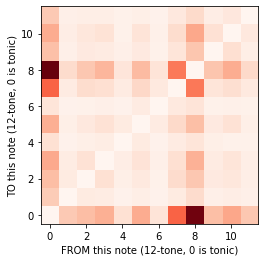

8928 in cluster, max distance = 0.4175299544639363
0.04 Chetes: Que Me Maten (Versión En Vivo)
0.05 Jimmy Johnson: Bring It On Home To Me
0.05 Natural Elements: Mayday
0.05 Last Exit: Discharge
0.05 Morcheeba: Public Displays Of Affection (KCRW Session / Live at Kampo Studios_ NYC 26/7/02)
0.05 Heartsrevolution: Ultraviolence (Les Petits Pilous Remix) [Bonus Track]
0.05 She & Him: Lingering Still
0.05 Gigi Finizio: La Voglia D'Amare
0.06 Heiner Goebbels: Der Abstieg zu den Menschen [Die Befreiung des Prometheus] (Heiner Goebbels)
0.06 Dj Cam: Angel Dust


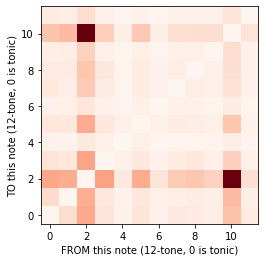

5415 in cluster, max distance = 0.9918840199150212
0.05 Lucky Dragons: In Gary's Room
0.05 Fightstar: Lost Like Tears In Rain
0.06 Boy George: Out Of Fashion
0.06 Femi Kuti: One Two
0.06 O Yuki Conjugate: OYC25.02
0.06 The Seeds: Baby baby baby
0.06 James Taylor feat. Toots Theilemans on harmonica: The Christmas Song (Chestnuts Roasting On An Open Fire)
0.06 Steal Vybe: The Luscious Queenstrumental
0.06 Lennie Tristano: It's Personal
0.06 Ordo Rosarius Equilibrio: Sons & Daughters of Lilith and Cain


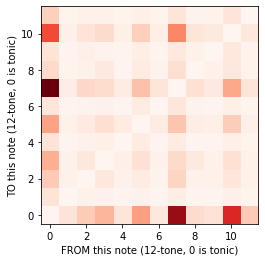

8895 in cluster, max distance = 0.4500205660014951
0.05 Willy DeVille: Steady Drivin' Man
0.05 Living Things: The Kingdom Will Fall
0.05 Tiago Iorc: Ticket to Ride
0.05 DC Project & Darioef: Just Tell Me
0.05 Helios Creed: Who Cares
0.05 Battles: Prismism
0.05 Lisa Loeb: Songwriting
0.05 Marlene Dietrich: Falling in love again
0.06 Them Wranch: On My Mind
0.06 Sarah Connor: If U Were My Man


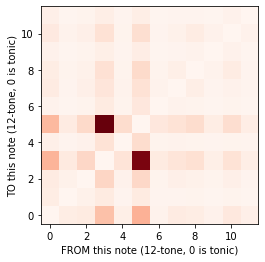

3494 in cluster, max distance = 0.8929181856227921
0.04 Cara Dillon: Green Grows The Laurel
0.05 The Ghost of A Thousand: Moved As Mountains_ Dreamt Of By The Sea (Live From Newquay '09)
0.05 Billie Jo Spears: He's On The Run Again
0.05 Los Traileros Del Norte: El Molino
0.06 John Stewart: Arkansas Breakout (LP Version)
0.06 A-Team: Show 'Em A Better Way
0.06 Daft Punk: Television Rules The Nation / Crescendolls
0.06 Syke 'n' Sugarstarr: Release Your Mind
0.06 Skillz: Nod Factor
0.06 Milt Jackson: Baggy's Blues


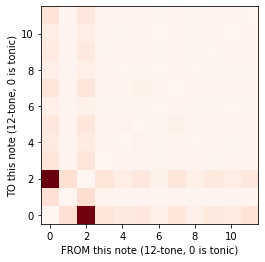

3057 in cluster, max distance = 0.8527591032088511
0.05 Spiritualized: Beautiful Happiness
0.05 Nero's Day At Disneyland: Theme For A Chase Scene Architecture
0.06 Los Caminantes: Mi Destino Fue Quererte
0.06 Roy Wood: [We're] On The Road Again
0.06 Explicit Samouraï: Prologue
0.06 Christina Rosenvinge: Lo Siento
0.06 Vital Remains: The night has a thousand eyes
0.06 Brad Mehldau: Buddha Realm
0.06 Wig Wam: Erection
0.06 Wim Mertens: The Whole


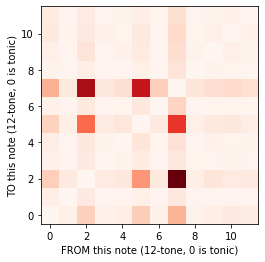

5688 in cluster, max distance = 0.512489118704933
0.05 Codeine: Loss Leader (Album)
0.05 Samon Kawamura: Morioka Sunset (JS Love)
0.05 Buckwheat Zydeco: Come Back Home Baby (Album Version)
0.05 Nadia Ali: Crash And Burn
0.06 Jack Radics: Love And Laughter
0.06 Safety Scissors vs. Kit Clayton: 9-11
0.06 Brett Eidman: He Just  Does Decks
0.06 Capdown: Headstrong
0.06 Automatic 7: Hold On
0.06 Brazilian Tropical Orchestra: Cuando Tu Me Quieras


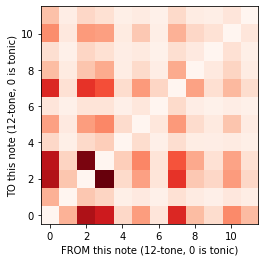

18996 in cluster, max distance = 0.35398155016219873
0.04 The Teen Queens: My Heart's Desire
0.04 Gyptian: You Never Know
0.04 Groove Collective: Valiha
0.04 Steve Bug: 1300 (Fred + Ginger)
0.04 Sleepy John Estes: Down South Blues
0.04 Dub War: Over Now (Haggis (Senser) Remix)
0.04 U2: God Part II
0.05 Doop: Doop - Sidney Berlin Ragtime Band
0.05 Arcangel: Volvio de Nuevo
0.05 Elva Hsiao: Shining Love


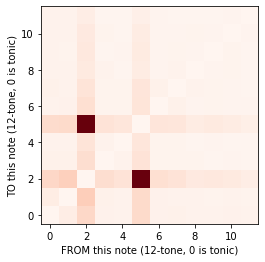

3395 in cluster, max distance = 0.6336322343426617
0.05 Slim: Pro nezhnost'
0.05 Critical Bill feat. Kutt Calhoun: What U Came Here For
0.06 Badly Drawn Boy: Walkman Demo 2
0.06 Juliet Turner: Business As Usual
0.06 Yank Rachel: Sweet Mama
0.06 Hercules: 7 Ways To Jack
0.06 Tieum: Fat & Bad
0.06 Francisco Mário: Pankararé
0.06 Maurice Chevalier: Notre Paris
0.07 Papa Charlie Jackson: Shave 'Em Dry (Take 2)


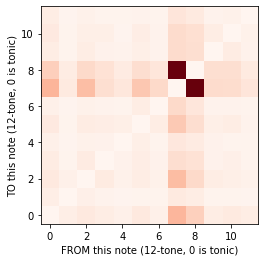

9996 in cluster, max distance = 0.9106377451589059
0.03 Helge Schneider: Das prangere ich an
0.04 Mac Dre_ Dubee: Crest Intro
0.04 Rodney O & Joe Cooley: Miss Crenshaw
0.05 Furthermore: We Need To Talk (She And I Album Version)
0.05 Ferras: Everybody Bleeds The Same
0.05 Jose Luis Perales: Ella Y Él
0.05 Judd and Maggie: Not Quite
0.05 Electro Hippies: Mistake
0.05 Rod Lee: Cotton Eyed (Rmx)
0.06 Ralph Stanley: Gloryland (Album Version)


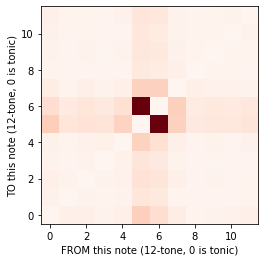

5219 in cluster, max distance = 0.6353812160437927
0.05 Grant Green: Past_ Present And Future
0.05 Diomedes Diaz;Ivan Zuleta: Muchas Gracias
0.05 Niños Mutantes: Lux
0.05 Michael Mayer: Craftworld
0.05 Cephas & Wiggins: Reno Factory
0.06 Brownie McGhee: Robbie-Doby Boogie
0.06 Keak Da Sneak: Motors N' Rear End
0.06 Frida Hyvönen: Once I Was A Serene Teenaged Child
0.06 Sandra Dahlberg: Förrän elden
0.06 Lumen: Burya


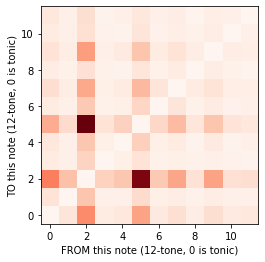

8012 in cluster, max distance = 0.3356977258954735
0.05 Pussy Dub Foundation: Struggle for pleasure
0.05 Jesse Harris: Gone Gone Gone
0.06 Rick Holmstrom: On the Vine
0.06 Irene Grandi: ( You Make Me Feel ) A Natural Woman
0.06 Sarah Slean: Day One
0.06 Jeannie C. Riley: Before The Next Teardrop Falls - Original
0.06 Punish Yourself: Old brother left hand
0.06 Dada: 7 dot 1
0.06 Ed Calle: Love After Dark
0.06 Blowing Free: Nessun Dorma


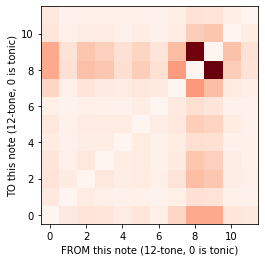

6084 in cluster, max distance = 0.6971508380614544
0.05 Tre Lux: Wild Horses
0.05 Moneybrother: Don't Call The Police
0.05 Gob: OK
0.05 Thomas Fersen: Je Suis Dev'nue La Bonne live
0.05 Luca Carboni: Colori
0.05 The Beatnuts: Hot (Album Version)
0.05 Jesse Rae: Scotland The Brave / Idio-syn-crazy
0.05 Brian Tyler: Battlefield Revealed
0.05 Z5: Sr Peko 1
0.06 Pretz: Goodbye Ferrers


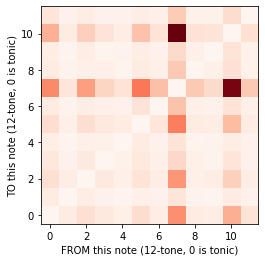

6886 in cluster, max distance = 0.9368271464898469
0.04 Der Plan: Es Werde Licht
0.05 Pat Boone: Tra-La-La
0.06 Trae: Till The Day I Drop
0.06 Tahiti 80: A Love From Outer Space (Console Remix)
0.06 Stereoheroes: Boom Slang (Rayflash Remix)
0.06 Ramallah: Oscar Cotton
0.06 El Barrio: Cuentale
0.06 Soft: La demande
0.06 Grub-Lee: Memory
0.06 Talitha Mackenzie: The MacKenzie Lullaby


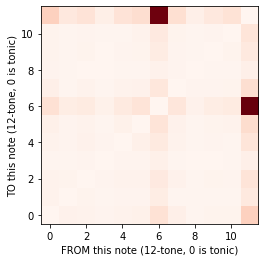

1043 in cluster, max distance = 0.8623544699097644
0.06 Billy J Kramer: Is There Any More At Home Like You (Stereo) (2009 Digital Remaster)
0.06 Decal: Superscum
0.07 Lloyd Cole And The Commotions: Perfect Skin
0.07 Skeewiff: Silently Losing The Plot
0.07 isis: Firdous E Bareen
0.07 Grandmaster Flash: Swagger
0.07 Michael W. Smith: Silent Night
0.07 Cherrelle: The Right Time (Featuring Keith Murray)
0.08 Lunasicc: Pose No Threat
0.08 New Bomb Turks: Sammer'd


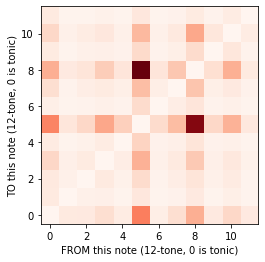

5733 in cluster, max distance = 0.48274921811456123
0.05 Ambelique: Cachito Mio
0.05 Celtic Frost: Inner Sanctum
0.06 Marc Dorsey: All I Do
0.06 Erika: El alma en pie (A dúo con Yahir)
0.06 Matia Bazar: Vacanze Romane (1998 Digital Remaster)
0.06 Dr Rockit: Café de Flore
0.06 Todd Terje / Akwaaba: Boozefinger
0.06 Lory Bianco: Forever Young
0.06 Ella Fitzgerald: Cow Cow Boogie
0.06 Kenny G: Peruvian Nights


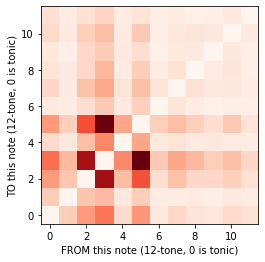

9065 in cluster, max distance = 0.37680227701016383
0.04 The Fontane Sisters: Nuttin' for Christmas
0.04 Maywood: Give Me Back My Love
0.04 Montserrat Caballé: Los primeros amores
0.05 Dora The Explorer: Boots' Special Day
0.05 Downhere: The Real Jesus (Acoustic)
0.05 Dave Mason: Give Me A Reason Why
0.05 Big Kahuna and the Copa Cat Pack: Pearly Shells
0.05 Delta Goodrem: Lost Without You
0.05 Gold Panda: Before We Talked
0.05 Phyllis Dillon: The Right Track


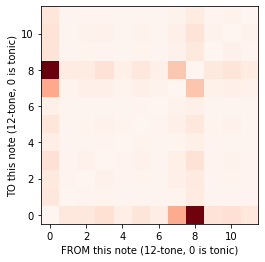

1455 in cluster, max distance = 0.8757827038593637
0.05 Anton Barbeau: Stewart Mason
0.05 Wyclef Jean featuring Youssou N' Dour & MB2: Diallo
0.06 Secret Shine: Silver Machine
0.06 Traxamillion: Jus Go feat. The Team
0.06 Earl Thomas Conley;Emmylou Harris: We Believe In Happy Endings
0.07 Coultrain: Girl Of My Dreams
0.07 MU330: Let Go Again
0.07 El Barrio: No vale la pena
0.08 Almedal: Du Skulle Aldrig Flytta Till Min Stad
0.08 Jungle Rot: Anorther Fix


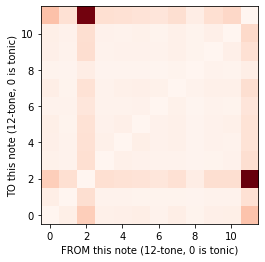

3750 in cluster, max distance = 0.8969592254079941
0.05 Al Petteway and Amy White: Hidden Wings
0.05 Ronnie Milsap: Any Day Now
0.05 Scott Wesley Brown: Lift Jesus High
0.05 1910 Fruitgum Company: Please Me_ Tease Me
0.06 Black Light Discipline: For All Your Heavy Hearted
0.06 The Oppressed: Fatal Blow
0.06 Garbage: Shut Your Mouth
0.06 Sheila On 7: Pria Kesepian
0.06 Dali's Dilemma: This Time Around
0.06 Andre Matos: Violence


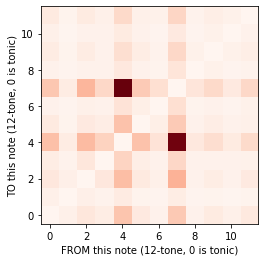

8252 in cluster, max distance = 0.9177132207025629
0.05 The Dials: From Fairyring Champion To False Pegasus
0.05 Magic Bullets: The Upstairs Flight
0.05 Nancys Rubias: Cancion para una siniestra
0.05 Sheila On 7: Berai
0.05 Jonathan Edwards: Everybody Knows Her (Live Version)
0.05 Anita Baker: Christmas Fantasy
0.06 The Lullaby Orchestra: Eight Days A Week
0.06 Superdrag: Load
0.06 Daisychain: Mamasei
0.06 Sound Team: Get Out


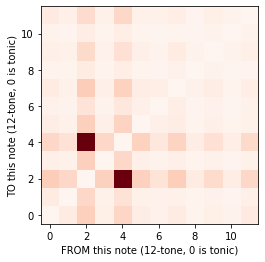

5483 in cluster, max distance = 0.9067097006571039
0.05 Flunk: Change My Ways
0.06 Young Buck: Look At Me Now
0.06 Hooters: Engine 999
0.06 Don Dixon: Lady With Dog
0.06 Fourplay: 101 Eastbound (Album Version)
0.06 King Diamond & Black Rose: Road Life
0.06 Eighteen Visions: Sonic Death Monkey
0.06 Silence: Downwards Deadhearts
0.06 Pete Escovedo / Sheila Escovedo: Happy Together
0.06 The Chameleons: Silence Sea and Sky


In [44]:
model = sklearn.cluster.MiniBatchKMeans(n_clusters=100).fit(np_intervals_per_song)
unique_labels = np.unique(model.labels_)

centers = []
for label in unique_labels:
    centers.append(np.mean(np_intervals_per_song[model.labels_ == label], axis=0).reshape(12, 12))

for center, label in zip(centers, unique_labels):
    plt.imshow(center, origin="lower", cmap="Reds")
    plt.xlabel("FROM this note (12-tone, 0 is tonic)")
    plt.ylabel("TO this note (12-tone, 0 is tonic)")
    plt.show()
    distances = np.sqrt(np.sum((np_intervals_per_song[model.labels_ == label] - center.reshape(-1))**2, axis=1))
    print(len(distances), "in cluster, max distance =", np.max(distances))
    sorter = np.argsort(distances)
    sorted_song_metadata = songs[model.labels_ == label, "metadata", ["artist_name", "title"]][sorter]
    for artist_title, dist in zip(sorted_song_metadata[:10].tolist(), distances[sorter][:10]):
        print(round(dist, 2), artist_title["artist_name"] + ": " + artist_title["title"])

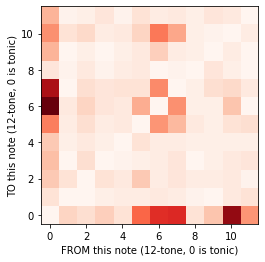

In [43]:
plt.imshow(np_intervals_per_song[
    (songs.metadata.artist_name == "The Dandy Warhols") &
    (songs.metadata.title == "The Last High")
][0].reshape(12, 12), origin="lower", cmap="Reds")
plt.xlabel("FROM this note (12-tone, 0 is tonic)")
plt.ylabel("TO this note (12-tone, 0 is tonic)");